# License

    Jupyter notebook for accessing CUDA
    Copyright (C) 2018 Andre.Brodtkorb@ifi.uio.no, changed in October by André Brodtkorb

    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <http://www.gnu.org/licenses/>.

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline

#Import packages we need
import numpy as np
import pycuda.compiler as cuda_compiler
from pycuda.gpuarray import GPUArray
import pycuda.driver as cuda_driver

from matplotlib import pyplot as plt

import IPythonMagic
from Timer import Timer

In [2]:
import pytest
from ipytest import run_pytest, clean_tests

In [3]:
%setup_logging
%cuda_context_handler context

Python version 3.6.6 (default, Sep 12 2018, 18:26:19) 
[GCC 8.0.1 20180414 (experimental) [trunk revision 259383]]
Registering context in user workspace
Creating context
PyCUDA version 2018.1.1
CUDA version (9, 1, 0)
Driver version 10000
Using 'Tesla K80' GPU
 => compute capability: (3, 7)
 => memory: 11308 / 11441 MB available
Created context handle <60045344>
Using CUDA cache dir /home/ubuntu/jupyter_notebooks/Andre Brodtkorb/MilanoGPU2018/notebooks/cuda_cache


In [23]:
cuda_kernel = """
__global__ void matrixVectorKernel(float* c, float* A, float* b, int a_rows, int a_cols) {
    unsigned int j = blockIdx.x*blockDim.x + threadIdx.x;
    
    //Out of bounds check
    if (j > a_rows) {
        return;
    }
    
    //Compute inner product of row of A with column of B
    float sum = 0.0f;
    for (int i=0; i<a_cols; ++i) {
        unsigned int k = j*a_cols + i;
        sum += A[k] * b[i];
    }
    
    //Write to global memory
    c[j] = sum;
}
"""
module = cuda_compiler.SourceModule(cuda_kernel)
kernel = module.get_function("matrixVectorKernel")
#matrixVectorKernel(float* c, float* A, float* b, int a_rows, int a_cols)
# THe arguments are Pointer, Pointer, Pointer, Int, Int
# PPPii
kernel.prepare("PPPii")

In [45]:
def gpuMatrixVector(a, b):
    #Create a stream of operations on the GPU
    stream = cuda_driver.Stream()
        
        
    #Upload data to the device
    #NOTE: We need to make sure that a=(a_rows, a_columns)
    # and that b=(a_colmuns, 1) (column vector)
    # and that c=(a_rows, 1)
    with Timer("Data allocation") as t:
        a_g = GPUArray(a.shape, np.float32)
        b_g = GPUArray(b.shape, np.float32)
        c_g = GPUArray(a.shape[0], np.float32)
        
    with Timer("A upload") as t:
        a_g.set_async(a, stream=stream)
        
    with Timer("b upload") as t:
        b_g.set_async(b, stream=stream)
    
    #NOTE: We need to change this so that the grid*block is x = 1, y = number of rows in A
    block_size = (256, 1, 1) #These need to be [x, y, z]
    grid_size = (int(np.ceil(a.shape[0] / float(block_size[0]))), 1, 1)

    #print("Block size is " + str(block_size))
    #print("Grid size is " + str(grid_size))
    
    #Execute program on device
    with Timer("Kernel execution") as t:
        for i in range(1000):
            kernel.prepared_async_call(grid_size, block_size, stream, \
                                       c_g.gpudata, a_g.gpudata, b_g.gpudata, \
                                       np.int32(a.shape[0]), np.int32(a.shape[1]))

    #Copy data from device to host
    with Timer("Allocate c") as t:
        c = np.empty((a.shape[0], 1), dtype=np.float32)
    with Timer("Download") as t:
        c_g.get(c)
    
    #Return our computed matrix-vector product
    return c

In [46]:
test_size = (2048, 2048)

#Create test input / output data
with Timer("Create test data") as t:
    a = np.random.random(test_size).astype(np.float32)
    b = np.random.random((test_size[1], 1)).astype(np.float32)
with Timer("Run whole function") as t:
    c = gpuMatrixVector(a, b)

Create test data: 73.318481 ms
Data allocation: 0.355244 ms
A upload: 2.272129 ms
b upload: 0.104427 ms
Kernel execution: 11.449337 ms
Allocate c: 0.011444 ms
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:39: DeprecationWarning: get() between arrays of different shape is deprecated and will be removed in PyCUDA 2017.x
Download: 1414.030552 ms
Run whole function: 1433.340311 ms


# After async kernel call
```
Create test data: 71.530104 ms
Data allocation: 0.355482 ms
A upload: 2.511978 ms
b upload: 0.131369 ms
Kernel execution: 0.080109 ms
Allocate c: 0.011921 ms
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:38: DeprecationWarning: get() between arrays of different shape is deprecated and will be removed in PyCUDA 2017.x
Download: 1.145840 ms
Run whole function: 8.275270 ms
```

# Before asychronous execution
```
Create test data: 68.140030 ms
Data allocation: 0.386000 ms
A upload: 2.456665 ms
b upload: 0.192165 ms
Kernel execution: 2.301931 ms
Allocate c: 0.012159 ms
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:43: DeprecationWarning: get() between arrays of different shape is deprecated and will be removed in PyCUDA 2017.x
Download: 0.215054 ms
Run whole function: 10.203123 ms
```

In [28]:
nx = np.array([200, 400, 800, 1600, 3200, 6400, 8000, 10000])
ny = nx

print(nx, ny)

[  200   400   800  1600  3200  6400  8000 10000] [  200   400   800  1600  3200  6400  8000 10000]


times = np.empty_like(nx)
for i in range(len(nx)):
    print("Nx = " + str(nx[i]), flush=True)
    #Size of our test
    test_size = (nx[i], ny[i])

    #Create test input / output data
    with Timer("Create test data") as t:
        a = np.random.random(test_size).astype(np.float32)
        b = np.random.random((test_size[1], 1)).astype(np.float32)
    with Timer("Run whole function") as t:
        c = gpuMatrixVector(a, b)
    times[i] = t.msecs
    
print(nx*ny)
print(times)
    
    

"""fig = plt.figure()
plt.subplot(1,3,1)
plt.imshow(a)
plt.subplot(1,3,2)
plt.imshow(b)
plt.subplot(1,3,3)
plt.imshow(c)
fig.show()"""

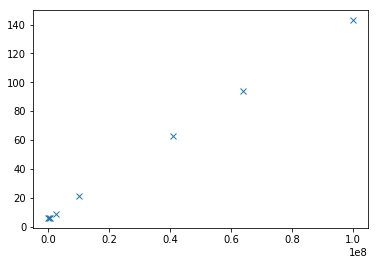

In [30]:
plt.figure()
plt.plot(nx*ny, times, 'x')

In [12]:
#Compute reference using Numpy
c_ref = np.dot(a, b)

#Sum of absolute differences
sad = np.sum(np.abs(c - c_ref))

#Print result
# print("C   = ", c)
# print("Ref = ", c_ref)
print("Sad = %.30f" % sad)
print("Per element error: " + str(sad / test_size[1]))

Sad = 0.000000000000000000000000000000
Per element error: 0.0


In [21]:
clean_tests()

def test_gpuMatrixVector():
    #Let us test a matrix of size 1x1
    a = np.ones((1, 1), dtype=np.float32)
    b = 2*np.ones((1, 1), dtype=np.float32)
    c = gpuMatrixVector(a, b)
    assert c == pytest.approx(2.0)
    
    #Test that the inner product works
    a = np.ones((1, 2), dtype=np.float32)
    b = 2*np.ones((2, 1), dtype=np.float32)
    c = gpuMatrixVector(a, b)
    assert c == pytest.approx(4.0)
    
    #Test a general matrix
    test_size = (4, 3)
    a = np.random.random(test_size).astype(np.float32)
    b = np.random.random((test_size[1], 1)).astype(np.float32)
    c = gpuMatrixVector(a, b)
    assert c == pytest.approx(a.dot(b), rel=1e-3)
    
run_pytest(filename='MatrixVectorTesting.ipynb', pytest_options=['-vvv'])

============================= test session starts ==============================
platform linux -- Python 3.6.6, pytest-3.8.2, py-1.6.0, pluggy-0.7.1 -- /usr/bin/python3
cachedir: .pytest_cache
rootdir: /home/ubuntu/jupyter_notebooks/Andre Brodtkorb/MilanoGPU2018/notebooks, inifile:
collecting ... collected 1 item

MatrixVectorTesting.py::test_gpuMatrixVector <- <ipython-input-21-ac8844f07e97> PASSED [100%]

=============================== warnings summary ===============================
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: DeprecationWarning: get() between arrays of different shape is deprecated and will be removed in PyCUDA 2017.x
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: DeprecationWarning: get() between arrays of different shape is deprecated and will be removed in PyCUDA 2017.x
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: DeprecationWarning: get() between arrays of different shape is 

0